<a href="https://colab.research.google.com/github/ngotancuong/datamining/blob/main/10_Neural_Networks_for_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 10. Neural Networks for text

**Turning text into numbers**



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import sys
os.chdir('/content/gdrive/My Drive/Teaching-task/myDM-MLcourse/ml-course/notebooks')
sys.path.append("/content/gdrive/My Drive/Teaching-task/myDM-MLcourse/ml-course/notebooks")
!pwd

/content/gdrive/My Drive/Teaching-task/myDM-MLcourse/ml-course/notebooks


In [ ]:
!pip install openml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
  Created wheel for openml: filename=openml-0.14.1-py3-none-any.whl size=146923 sha256=4e1d7fddaf93bcd7a280b870911ced3380536ec83ce2d8402d9f371fd4a4b275
  Stored in directory: /root/.cache/pip/wheels/75/bc/fd/739778254a2881ef96b139d0aaf60c6d4f9130bb1459b48f10
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=91d66d504d9fc8b01008ec65d0f6e27def007c20fa2275297e43d90647b23244
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built openml liac-arff


In [ ]:
# Global imports and settings
from preamble import *
import tensorflow as tf
import tensorflow.keras as keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

%matplotlib inline
interactive = True # Set to True for interactive plots
if interactive:
    fig_scale = 0.5
    plt.rcParams.update(print_config)
else: # For printing
    fig_scale = 0.4
    plt.rcParams.update(print_config)

## Overview
* Word embeddings
    * Word2Vec, FastText, GloVe
    * Neural networks on word embeddings
* Sequence-to-sequence models
    * Self-attention
    * Transformer models

## Bag of word representation
* First, build a _vocabulary_ of all occuring words. Maps every word to an index.
* Represent each document as an $N$ dimensional vector (top-$N$ most frequent words)
    * One-hot (sparse) encoding: 1 if the word occurs in the document
* Destroys the order of the words in the text (hence, a 'bag' of words)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/bag_of_words.png" alt="ml" style="width: 60%"/>

Example: IMBD review database
* 50,000 reviews, labeled positive (1) or negative (0)
    * Every row (document) is one review, no other input features
    * Already tokenized. All markup, punctuation,... removed

In [ ]:
from keras.datasets import imdb
word_index = imdb.get_word_index()
print("Text contains {} unique words".format(len(word_index)))

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(index_from=0)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

for r in [0,5,10]:
    print("\nReview {}:".format(r),' '.join([reverse_word_index.get(i, '?') for i in train_data[r]][0:50]))

1641221/1641221 [==============================] - 0s 0us/step
Text contains 88584 unique words
17464789/17464789 [==============================] - 0s 0us/step

Review 0: the this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved

Review 5: the begins better than it ends funny that the russian submarine crew outperforms all other actors it's like those scenes where documentary shots br br spoiler part the message dechifered was contrary to the whole story it just does not mesh br br

Review 10: the french horror cinema has seen something of a revival over the last couple of years with great films such as inside and switchblade romance bursting on to the scene maléfique preceded the revival just slightly but stands head and shoulders over most moder

### Bag of words with one-hot-encoding
* Encoded review: shows the list of word IDs. Words are sorted by frequency of occurance.
    * Allows to easily remove the most common and least common words
* One-hot-encoded review: '1' if the word occurs.
    * Only the first 100 of 10000 values are shown

In [ ]:
# Custom implementation of one-hot-encoding.
# dimension is the dimensionality of the output (default 10000).
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # create empty vector of length N
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data, dimension=len(word_index))
x_test = vectorize_sequences(test_data, dimension=len(word_index))

In [ ]:
print("Review {}:".format(3),' '.join([reverse_word_index.get(i, '?') for i in train_data[3]][0:80]))
print("\nEncoded review: ", train_data[3][0:80])
print("\nOne-hot-encoded review: ", x_train[3][0:80])

Review 3: the the scots excel at storytelling the traditional sort many years after the event i can still see in my mind's eye an elderly lady my friend's mother retelling the battle of culloden she makes the characters come alive her passion is that of an eye witness one to the events on the sodden heath a mile or so from where she lives br br of course it happened many years before she was born but you wouldn't guess from

Encoded review:  [1, 1, 18606, 16082, 30, 2801, 1, 2037, 429, 108, 150, 100, 1, 1491, 10, 67, 128, 64, 8, 58, 15302, 741, 32, 3712, 758, 58, 5763, 449, 9211, 1, 982, 4, 64314, 56, 163, 1, 102, 213, 1236, 38, 1794, 6, 12, 4, 32, 741, 2410, 28, 5, 1, 684, 20, 1, 33926, 7336, 3, 3690, 39, 35, 36, 118, 56, 453, 7, 7, 4, 262, 9, 572, 108, 150, 156, 56, 13, 1444, 18, 22, 583, 479, 36]

One-hot-encoded review:  [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 0

### Word counts
* Count the number of times each word appears in the document
* Example using sklearn `CountVectorizer` (on 2 documents)
* In practice, we also:
    * Preprocess the text (tokenization, stemming, remove stopwords, ...)
    * Use _n-grams_ ("not terrible", "terrible acting",...), _character n-grams_ ('ter', 'err', 'eri',...)
    * Scale the word-counts (e.g. L2 normalization or TF-IDF)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Fit count vectorizer on a few documents (here: 2)
line = [' '.join([reverse_word_index.get(i, '?') for i in train_data[d]][0:50]) for d in range(2)]
vect = CountVectorizer()
vect.fit(line)
print("Vocabulary (feature names) after fit:", vect.get_feature_names_out())

# Transform the data
# Returns a sparse matrix
X = vect.transform(line)
print("Count encoding doc 1:", X.toarray()[0])
print("Count encoding doc 2:", X.toarray()[1])

Vocabulary (feature names) after fit: ['actor' 'amazing' 'an' 'and' 'are' 'as' 'bad' 'be' 'being' 'best' 'big'
 'boobs' 'brilliant' 'but' 'came' 'casting' 'cheesy' 'could' 'describe'
 'direction' 'director' 'ever' 'everyone' 'father' 'film' 'from' 'giant'
 'got' 'had' 'hair' 'horror' 'hundreds' 'imagine' 'is' 'island' 'just'
 'location' 'love' 'loved' 'made' 'movie' 'movies' 'music' 'myself'
 'norman' 'now' 'of' 'on' 'paper' 'part' 'pin' 'played' 'plot' 'really'
 'redford' 'ridiculous' 'robert' 'safety' 'same' 'scenery' 'scottish'
 'seen' 'so' 'story' 'suited' 'terrible' 'the' 'there' 'these' 'they'
 'thin' 'this' 'to' 've' 'was' 'words' 'worst' 'you']
Count encoding doc 1: [1 1 1 2 0 1 0 0 2 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 2 1
 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 2 1 1 0 1 1 1 0 4 1 0 1 0 1 0 0
 1 0 0 1]
Count encoding doc 2: [0 0 0 3 1 0 1 1 0 1 2 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0
 1 0 1 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 1 4

### Classification
* With this tabular representation, we can fit any model (e.g. Logistic regression)
* Visualize coefficients: which words are indicative for positive/negative reviews?

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# Fit CountVectorizer on the first 5000 reviews
data_size = 5000 # You can get a few % better in the full dataset, but takes longer
train_text = [' '.join([reverse_word_index.get(i, '?') for i in train_data[d]]) for d in range(data_size)]
test_text = [' '.join([reverse_word_index.get(i, '?') for i in test_data[d]]) for d in range(data_size)]

vect = CountVectorizer()
train_text_vec = vect.fit_transform(train_text)
test_text_vec = vect.transform(test_text)

lr = LogisticRegressionCV().fit(train_text_vec, train_labels[:data_size])
acc = lr.score(test_text_vec, test_labels[:data_size])
print("Logistic regression accuracy:",acc)

Logistic regression accuracy: 0.8542


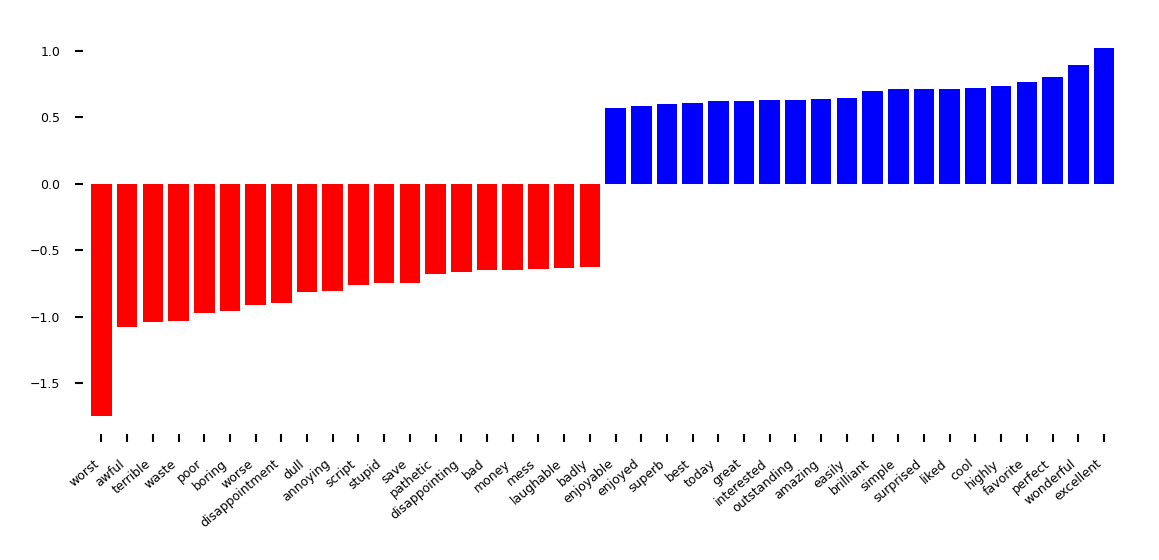

In [ ]:
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n

    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)
plt.figure(figsize=(9*fig_scale, 3.5*fig_scale))
plot_important_features(lr.coef_.ravel(), np.array(vect.get_feature_names_out()), top_n=20, rotation=40)
ax = plt.gca()

### Preprocessing
* Tokenization: how to you split text into words? On spaces only? Also -, ` ?
* Stemming: naive reduction to word stems. E.g. 'the meeting' to 'the meet'
    * Lemmatization: smarter reduction (NLP-based). E.g. distinguishes between nouns and verbs
* Discard stop words ('the', 'an',...)
* Only use $N$ (e.g. 10000) most frequent words
 * Or, use a hash function (risks collisions)
* n-grams: Use combinations of $n$ adjacent words next to individual words
    * e.g. 2-grams: "awesome movie", "movie with", "with creative", ...
* Character n-grams: combinations of $n$ adjacent letters: 'awe', 'wes', 'eso',...
* Useful libraries: [nltk](https://www.nltk.org/), [spaCy](https://spacy.io/), [gensim](https://radimrehurek.com/gensim/),...

### Scaling
* L2 Normalization (vector norm): sum of squares of all word values equals 1
    * Normalized Euclidean distance is equivalent to cosine distance
    * Works better for distance-based models (e.g. kNN, SVM,...)
$$ t_i = \frac{t_i}{\| t\|_2 }$$

* Term Frequency - Inverted Document Frequency (TF-IDF)
    * Scales value of words by how frequently they occur across all $N$ documents
    * Words that only occur in few documents get higher weight, and vice versa

$$ t_i = t_i \cdot log(\frac{N}{|\{d \in D : t_i \in d\}|})$$

* Usually done in preprocessing, e.g. sklearn `Normalizer` or `TfidfTransformer`
    * L2 normalization can also be done in a `Lambda` layer
```python
model.add(Lambda(lambda x: tf.linalg.normalize(x,axis=1)))
```

## Neural networks on bag of words
* We can also build neural networks on bag-of-word vectors
    - E.g. Use one-hot-encoding with 10000 most frequent words
* Simple model with 2 dense layers, ReLU activation, dropout
    - Binary classification: single output node, sigmoid activation, binary cross-entropy loss
    
``` python
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
```

In [ ]:
# Load data with 10000 words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# One-hot-encoding
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
# Convert 0/1 labels to float
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [ ]:
# Callback for plotting
# TODO: move this to a helper file

from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

# For plotting the learning curve in real time
class TrainingPlot(Callback):

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.max_acc = 0

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):

        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.max_acc = max(self.max_acc, logs.get('val_accuracy'))

        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:

            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))

            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure(figsize=(8*fig_scale,3*fig_scale))
            plt.plot(N, self.losses, lw=2, c="b", linestyle="-", label = "train_loss")
            plt.plot(N, self.acc, lw=2, c="r", linestyle="-", label = "train_acc")
            plt.plot(N, self.val_losses, lw=2, c="b", linestyle=":", label = "val_loss")
            plt.plot(N, self.val_acc, lw=2, c="r", linestyle=":", label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}, Max Acc {:.4f}]".format(epoch, self.max_acc))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

### Evaluation
* Take a validation set of 10,000 samples from the training set
* The validation loss peaks after a few epochs, after which the model starts to overfit
    * Performance is better than Logistic regression

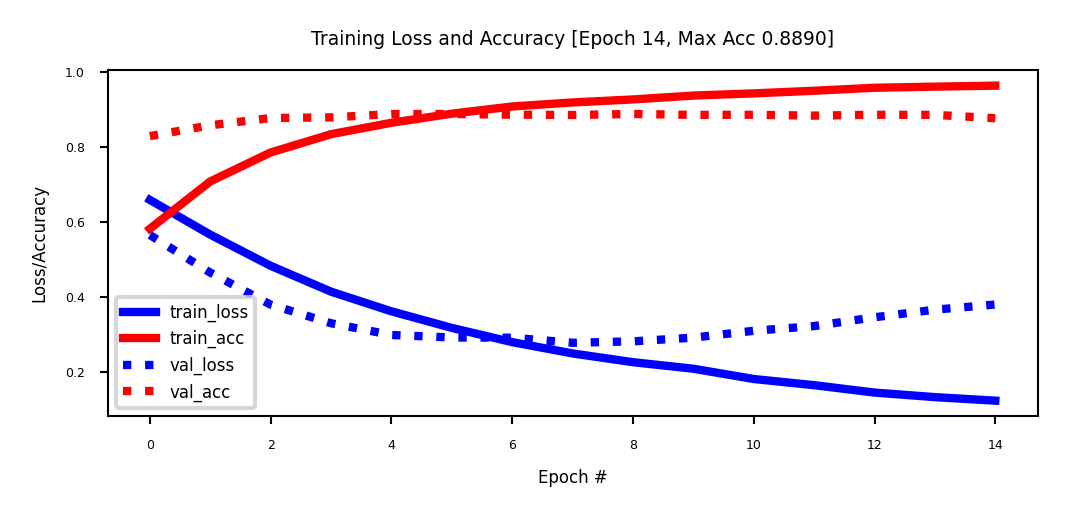

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:]

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(partial_x_train, partial_y_train,
                    epochs=15, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val), callbacks=[plot_losses])

#### Predictions
Let's look at a few predictions:

In [ ]:
predictions = model.predict(x_test)
print("Review 0: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[0]]))
print("Predicted positiveness: ", predictions[0])
print("\nReview 16: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[16]]))
print("Predicted positiveness: ", predictions[16])

782/782 [==============================] - 2s 3ms/step
Review 0:  ? please give this one a miss br br ? ? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ? so all you madison fans give this a miss
Predicted positiveness:  [0.068]

Review 16:  ? from 1996 first i watched this movie i feel never reach the end of my satisfaction i feel that i want to watch more and more until now my god i don't believe it was ten years ago and i can believe that i almost remember every word of the dialogues i love this movie and i love this novel absolutely perfection i love willem ? he has a strange voice to spell the words black night and i always say it for many times never being bored i love the music of it's so much made me come into another world deep in my heart anyone can feel what i feel and anyone c

## Word Embeddings
* A word embedding is a numeric vector representation of a word
    * Can be manual or _learned_ from an existing representation (e.g. one-hot)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_embeddings.png" alt="ml" style="width: 60%; margin-left: auto; margin-right: auto;">

### Learning embeddings from scratch
* Input layer uses fixed length documents (with 0-padding). 2D tensor (samples, max_length)
* Add an _embedding layer_ to learn the embedding
    * Create $n$-dimensional one-hot encoding. Yields a 3D tensor (samples, max_length, $n$)
    * To learn an $m$-dimensional embedding, use $m$ hidden nodes. Weight matrix $W^{n x m}$
    * Linear activation function: $\mathbf{X}_{embed} = W \mathbf{X}_{orig}$. 3D tensor (samples, max_length, $m$)
* Combine all word embeddings into a document embedding (e.g. global pooling).
* Add (optional) layers to map word embeddings to the output. Learn embedding weights from data.


<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_embedding_layer.png" alt="ml" style="width: 60%; margin-left: auto; margin-right: auto;">

Let's try this:

```python
max_length = 100 # pad documents to a maximum number of words
vocab_size = 10000 # vocabulary size
embedding_length = 20 # embedding length (more would be better)

model = models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_length, input_length=max_length))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(1, activation='sigmoid'))
```

In [ ]:
max_length = 100 # pad documents to a maximum number of words
vocab_size = 10000 # vocabulary size
embedding_length = 20 # embedding length

# define the model
model = models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_length, input_length=max_length))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 20)           200000    
                                                                 
 global_average_pooling1d (  (None, 20)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 200021 (781.33 KB)
Trainable params: 200021 (781.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* Training on the IMDB dataset: slightly worse than using bag-of-words?
    * Embedding of dim 20 is very small, should be closer to 100 (or 300)
    * We don't have enough data to learn a really good embedding from scratch


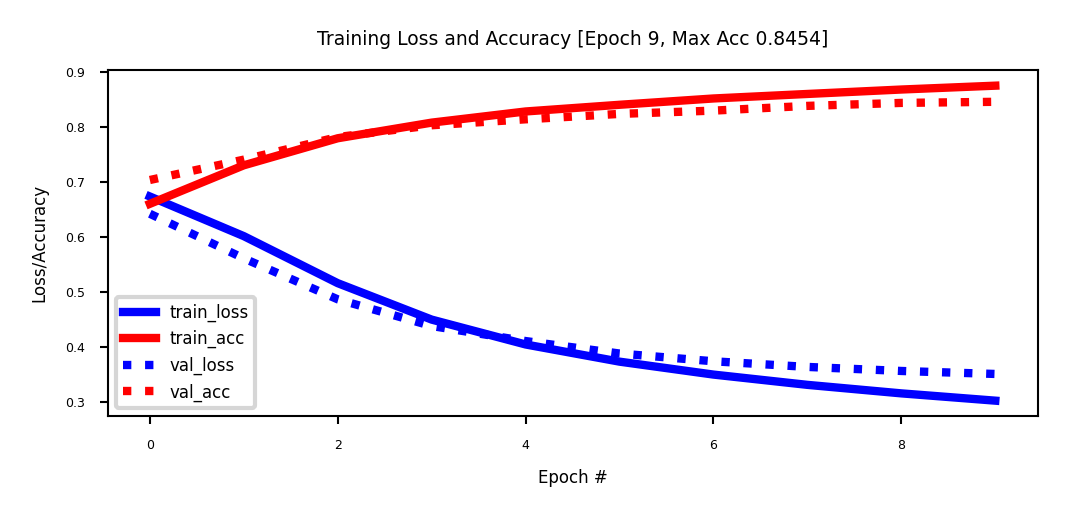

In [ ]:
from keras.utils import pad_sequences

# Load reviews again
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# Turn word ID's into a 2D integer tensor of shape `(samples, maxlen)`
x_train = pad_sequences(x_train, maxlen=max_length)
x_test = pad_sequences(x_test, maxlen=max_length)

model.fit(x_train, y_train, epochs=10, verbose=0,
          batch_size=32, validation_split=0.2, callbacks=[plot_losses]);

### Pre-trained embeddings
* With more data we can build better embeddings, but we also need more labels
* Solution: learn embedding on auxiliary task that doesn't require labels
    * E.g. given a word, predict the surrounding words.
    * Also called self-supervised learning. Supervision is provided by data itself
* Freeze embedding weights to produce simple word embeddings, or finetune to a new tasks
* Most common approaches:
    * Word2Vec: Learn neural embedding for a word based on surrounding words
    * FastText: learns embedding for character n-grams
        * Can also produce embeddings for new, unseen words
    * GloVe (Global Vector): Count co-occurrences of words in a matrix
        * Use a low-rank approximation to get a latent vector representation

#### Word2Vec
- Move a window over text to get $C$ context words ($V$-dim one-hot encoded)
- Add embedding layer with $N$ linear nodes, global average pooling, and softmax layer(s)
- CBOW: predict word given context, use weights of last layer $W^{'}_{NxV}$ as embedding
- Skip-Gram: predict context given word, use weights of first layer $W^{T}_{VxN}$ as embedding
    - Scales to larger text corpora, learns relationships between words better

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/09_word_embeddings_3.png" alt="ml" style="width: 55%; margin-left: auto; margin-right: auto;"/>

#### Word2Vec properties
* Word2Vec happens to learn [interesting relationships](https://www.aclweb.org/anthology/N13-1090/) between words
    * Simple vector arithmetic can map words to plurals, conjugations, gender analogies,...
    * e.g. Gender relationships: $vec_{king} - vec_{man} + vec_{woman} \sim vec_{queen}$
    * PCA applied to embeddings shows Country - Capital relationship
* Careful: embeddings can capture [gender and other biases](https://arxiv.org/abs/1607.06520) present in the data.
    * Important unsolved problem!

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/word2vec.png" alt="ml" style="width: 80%; margin-left: auto; margin-right: auto;"/>

### Doc2Vec
* Alternative way to combine word embeddings (instead of global pooling)
* Adds a paragraph (or document) embedding: learns how paragraphs (or docs) relate to each other
    * Captures document-level semantics: context and meaning of entire document
* Can be used to determine semantic similarity between documents.
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/doc2vec.png" alt="ml" style="width:50%; margin-left: auto; margin-right: auto;"/>

#### FastText
* Limitations of Word2Vec:
    * Cannot represent new (out-of-vocabulary) words
    * Similar words are learned independently: less efficient (no parameter sharing)
        * E.g. 'meet' and 'meeting'
* FastText: same model, but uses _character n-grams_
    * Words are represented by all character n-grams of length 3 to 6
        * "football" 3-grams: <fo, foo, oot, otb, tba, bal, all, ll>
    * Because there are so many n-grams, they are hashed (dimensionality = bin size)
    * Representation of word "football" is sum of its n-gram embeddings
* Negative sampling: also trains on random negative examples (out-of-context words)
    * Weights are updated so that they are _less_ likely to be predicted

#### Global Vector model (GloVe)
* Builds a co-occurence matrix $\mathbf{X}$: counts how often 2 words occur in the same context
* Learns a k-dimensional embedding $W$ through matrix factorization with rank k
    * Actually learns 2 embeddings $W$ and $W'$ (differ in random initialization)
* Minimizes loss $\mathcal{L}$, where $b_i$ and $b'_i$ are bias terms and $f$ is a weighting function

$$\mathcal{L} = \sum_{i,j=1}^{V} f(\mathbf{X}_{ij}) (\mathbf{w_i} \mathbf{w'_j} + b_i + b'_j - log(\mathbf{X}_{ij}))^2$$

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/glove3.png" alt="ml" style="width: 80%; margin-left: auto; margin-right: auto;"/>

Let's try this

* Download the [GloVe embeddings trained on Wikipedia](https://nlp.stanford.edu/projects/glove)
* We can now get embeddings for 400,000 English words
* E.g. 'queen' (in 100-dim):

In [ ]:
# To find the original data files, see
# http://nlp.stanford.edu/data/glove.6B.zip
# http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz

import tarfile

data_dir = '../data/glove.6B'
# Build an index so that we can later easily compose the embedding matrix
embeddings_index = {}
with open(os.path.join(data_dir, 'glove.6B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embeddings_index['queen']

array([-0.5  , -0.708,  0.554,  0.673,  0.225,  0.603, -0.262,  0.739,
       -0.654, -0.216, -0.338,  0.245, -0.515,  0.857, -0.372, -0.588,
        0.306, -0.307, -0.219,  0.784, -0.619, -0.549,  0.431, -0.027,
        0.976,  0.462,  0.115, -0.998,  1.066, -0.208,  0.532,  0.409,
        1.041,  0.249,  0.187,  0.415, -0.954,  0.368, -0.379, -0.68 ,
       -0.146, -0.201,  0.171, -0.557,  0.719,  0.07 , -0.236,  0.495,
        1.158, -0.051,  0.257, -0.091,  1.266,  1.105, -0.516, -2.003,
       -0.648,  0.164,  0.329,  0.048,  0.19 ,  0.661,  0.081,  0.336,
        0.228,  0.146, -0.51 ,  0.638,  0.473, -0.328,  0.084, -0.785,
        0.099,  0.039,  0.279,  0.117,  0.579,  0.044, -0.16 , -0.353,
       -0.049, -0.325,  1.498,  0.581, -1.132, -0.607, -0.375, -1.181,
        0.801, -0.5  , -0.166, -0.706,  0.43 ,  0.511, -0.803, -0.666,
       -0.637, -0.36 ,  0.133, -0.561], dtype=float32)

Same simple model, but with frozen GloVe embeddings: much worse!
```python
embedding_layer = layers.Embedding(input_dim=10000, output_dim=100,
                                   input_length=max_length, trainable=False)
embedding_layer.set_weights([weights]) # set pre-trained weigths
model = models.Sequential([
    embedding_layer, layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')]
```

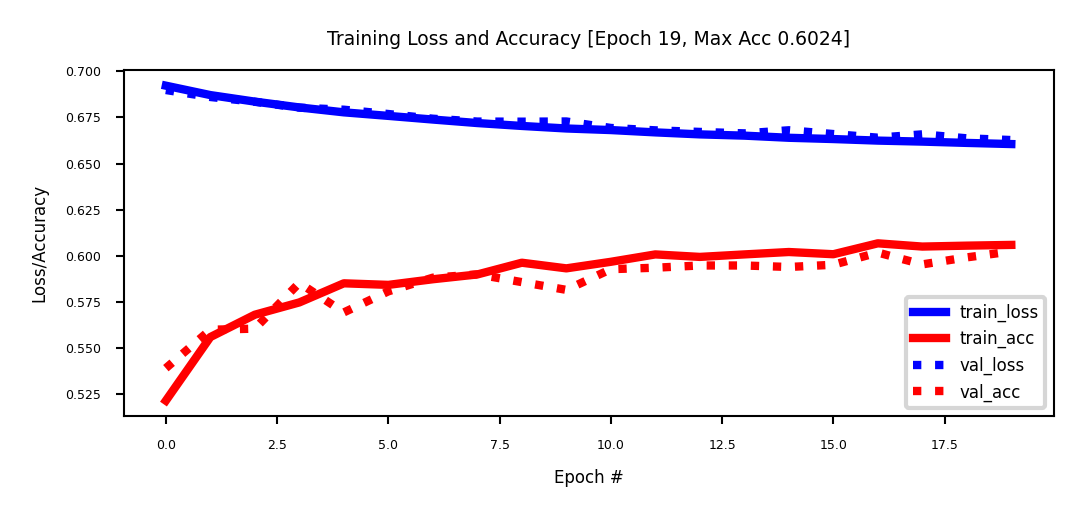

In [ ]:
embedding_dim = 100

# Create embedding layer
embedding_layer = layers.Embedding(input_dim=10000,
                                   output_dim=embedding_dim,
                                   input_length=max_length,
                                   trainable=False)

# define the model
model = models.Sequential()
model.add(embedding_layer)
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(1, activation='sigmoid'))

# Set pre-trained GloVe weights for the embedding layer
weights = np.zeros((10000, embedding_dim))
cnt = 0
for word, i in word_index.items():
    if i < 10000:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            weights[i] = embedding_vector
        else:
            cnt += 1
print(cnt, "unknown words")
embedding_layer.set_weights([weights])

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(x_train, y_train, epochs=20, verbose=0,
          batch_size=32, validation_split=0.2, callbacks=[plot_losses]);

## Sequence-to-sequence (seq2seq) models
* Global average pooling or flattening destroys the word order
* We need to model sequences explictly, e.g.:
    * 1D convolutional models: run a 1D filter over the input data
        * Fast, but can only look at small part of the sentence
    * Recurrent neural networks (RNNs)
        * Can look back at the entire previous sequence
        * Much slower to train, have limited memory in practice
    * Attention-based networks (Transformers)
        * Best of both worlds: fast and very long memory

### seq2seq models
* Produce a series of output given a series of inputs over time
* Can handle sequences of different lengths
    * Label-to-sequence, Sequence-to-label, seq2seq,...
    * Autoregressive models (e.g. predict the next character, unsupervised)


<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_seq2seq.png" alt="ml" style="width: 80%; margin-left: auto; margin-right: auto;"/>

### 1D convolutional networks
* Similar to 2D convnets, but moves only in 1 direction (time)
    * Extract local 1D patch, apply filter (kernel) to every patch
    * Pattern learned can later be recognized elsewhere (translation invariance)
* Limited memory: only sees a small part of the sequence (receptive field)
    * You can use multiple layers, dilations,... but becomes expensive
* Looks at 'future' parts of the series, but can be made to look only at the past
    * Known as 'causal' models (not related to causality)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_1dconv.png" alt="ml" style="width:100%;"/>

* Same embedding, but add 2 `Conv1D` layers and `MaxPooling1D`. Better!
```python
model = models.Sequential([
        embedding_layer,
        layers.Conv1D(32, 7, activation='relu'),
        layers.MaxPooling1D(5),
        layers.Conv1D(32, 7, activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(1, activation='sigmoid')]
```

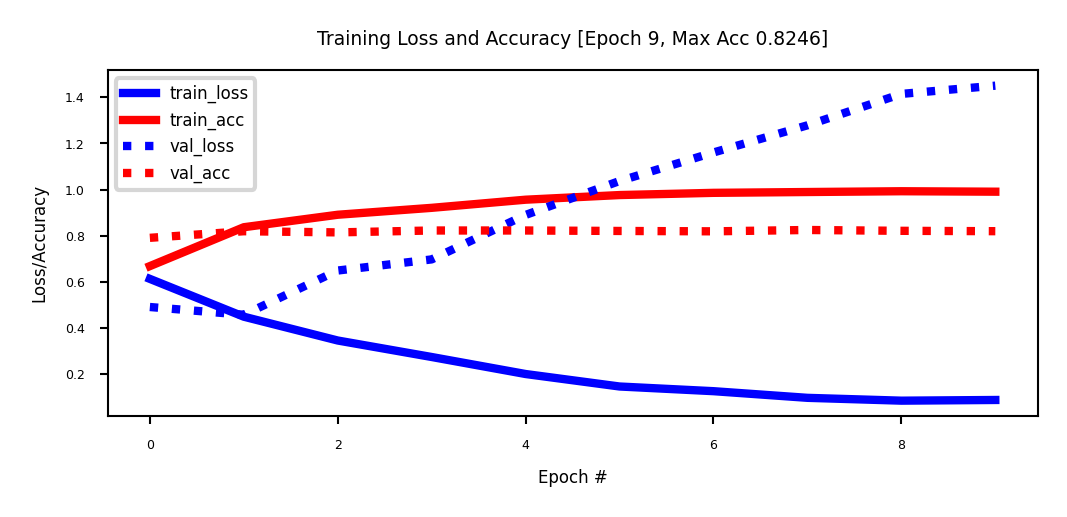

157/157 [==============================] - 93s 594ms/step - loss: 0.0872 - accuracy: 0.9908 - val_loss: 1.4506 - val_accuracy: 0.8194


In [ ]:
max_words = 400000
model = models.Sequential()
model.add(layers.Embedding(max_words, 128, input_length=max_length))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.compile(optimizer="rmsprop",
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[plot_losses])


### Recurrent neural networks (RNNs)
* Adds a recurrent connection that concats previous output to next input
    * Hidden layer
${\color{orange} h_t} = \sigma \left( {\color{orange} W } \left[ \begin{array}{c} {\color{blue}x}_t \\ {\color{orange} h}_{t-1} \end{array} \right] + b \right)$
* Unbounded memory, but training requires _backpropagation through time_
    * Requires storing previous network states (slow + lots of memory)
    * Vanishing gradients strongly limit practical memory
* Improved with _gating_: learn what to input, forget, output (LSTMs, GRUs,...)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_rnn.png" alt="ml" style="width:70%;"/>

### Simple self-attention
* Compute dot product of input vector $x_i$ with every $x_j$ (including itself): ${\color{Orange} w_{ij}}$
* Compute softmax over all these weights (positive, sum to 1)
* Multiply by each input vector, and sum everything up
* Can be easily vectorized: ${\color{green} Y}^T = {\color{orange} W}{\color{blue} X^T}$, ${\color{orange} W} = \textrm{softmax}( {\color{blue} X}^T {\color{blue}X} )$

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_selfattention.png" alt="ml" style="width:70%;"/>

### Simple self-attention (2)
* Output is mostly influenced by the current input (${\color{Orange} w_{ii}}$ is largest)
    * Mixes in information from other inputs according to how _similar_ they are
* Doesn't learn (no parameters), the embedding of ${\color{blue} X}$ defines self-attention
* ${\color{green} Y}^T = {\color{orange} W}{\color{blue} X^T}$ is _linear_, vanishing gradients only through softmax
* Has no problem looking _very_ far back in the sequence
* Operates on _sets_ (permutation invariant): allows img-to-set, set-to-set,... tasks
    * No access to sequence. For seq tasks we encode sequence in embedding

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_selfattention.png" alt="ml" style="width:40%;"/>

### Simple self-attention layer
* Let's add a simple self-attention layer to our movie sentiment model
* Without self-attention, every word would contribute independently from others
    * Exactly as in a bag-of-words model
    * The word _terrible_ will likely result in a negative prediction

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_selfattention_layer.png" alt="ml" style="width:40%;"/>

### Simple self-attention layer
* Self-attention can learn that the meaning on the word _terrible_ is inverted by the presence of the word _not_, even if it is further away in the sequence.
* In general, each self attention layer can learn specific relationships between words (e.g. inversion). We'll need many of them.

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_selfattention_negation.png" alt="ml" style="width:40%;"/>

### Standard self-attention
* Inputs occur in one of 3 positions in the self-attention layer:
    * Value $v$: input vector that provides the output, weighted by:
    * Query $q$: the vector that corresponds to the wanted _output_
    * Key $k$: The vector that the query is matched aganinst
* Works as a soft version of a dictionary, in which:
    * Every key matches the query to some extent (w.r.t. its dot product)
    * A weighted mixture of all values (normalized by softmax)

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_selfattention_kqv.png" alt="ml" style="width:30%;"/>

### Standard self-attention
* We want to _learn_ how each of these interact by adding learned transformations
    * $k_i = K x_i + b_k$
    * $q_i = Q x_i + b_q$
    * $v_i = V x_i + b_v$
* Makes self-attention more flexible, learnable
* Learn what to pay attention to in the input (e.g. sequence, image,...)
    
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_selfattention_kqv2.png" alt="ml" style="width:20%;"/>

### Standard self-attention (2)
* Inputs can have multiple relationships with each other (e.g. negation, strengtening,...)
* To learn these in parallel, we can split the self-attention in multiple heads
* Input vector is embedded (linearly) into lower dimensionality, multiple times

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_multihead_attention.png" alt="ml" style="width:50%;"/>

### Standard self-attention (3)
* The softmax operation can still lead to vanishing gradients (unless values are small)
    * We can scale the dot product by the input dimension $k$: ${\color{orange}w^{'}_{ij}} = \frac{{\color{blue} x_i}^T \color{blue} x_j}{\sqrt{k}}$



## Transformer model
* Repeat self-attention multiple times in controlled fashion
* Works for sequences, images, graphs,... (learn how sets of objects interact)
* Models consist of multiple transformer blocks, usually:
    * Layer normalization (every input is normalized independently)
    * Self-attention layer (learn interactions)
    * Residual connections (preserve gradients in deep networks)
    * Feed-forward layer (learn mappings)
    

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_transformer_model.png" alt="ml" style="width:60%;"/>

### Positional encoding
* We need some way to tell the self-attention layer about position in sequencet
* Represent position by vectors, using some easy-to-learn predictable pattern
    * Add these encodings to vector embeddings
    * Give information on how far one input is fron the others

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/10_encoding.png" alt="ml" style="width:60%;"/>

## Summary
* Bag of words representations
    * Useful, but limited, since they destroy the order of the words in text
* Word embeddings
    * Learning word embeddings from labeled data is hard, you may need a lot of data
    * Pretrained word embeddings
        * Word2Vec: learns good embeddings and interesting relationships
        * FastText: can also compute embeddings for entirely new words
        * GloVe: also takes the global context of words into account
* Sequence-to-sequence models
    * 1D convolutional nets (fast, limited memory)
    * RNNs (slow, also quite limited memory)
    * Self-attention (allows very large memory)
* Transformers

Acknowledgement

Several figures came from the excellent [VU Deep Learning course](https://dlvu.github.io/)